In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import graphviz as gr

import seaborn as sns
from scipy.special import expit

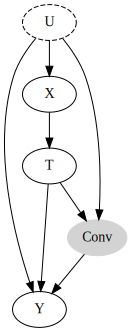

In [2]:
cop_dag = gr.Digraph()



cop_dag.edge("U", "X")
cop_dag.edge("U", "Y")
cop_dag.edge("U", "Conv")

cop_dag.edge("X", "T")

cop_dag.edge("T", "Conv")
cop_dag.edge("T", "Y")
cop_dag.edge("Conv", "Y")


cop_dag.node("Conv", color="lightgrey", style="filled")
cop_dag.node("U", style="dashed")

cop_dag

## Binary T

In [3]:
n = 100000

np.random.seed(123)

u = np.random.uniform(-0.5, 0.5, n)
x = np.round(pd.IntervalIndex(pd.qcut(np.random.normal(u, 0.5), 4, duplicates="drop")).mid, 2)
ps = expit(x)
t = np.random.binomial(1, ps)

conv_0 = np.random.binomial(1, expit(np.random.normal(-u)))
conv_1 = np.random.binomial(1, expit(np.random.normal(-u + 1)))
conv = conv_0*(1-t) + conv_1*t


y_0 = np.random.normal(20 -10*u, 0.1)*conv_0
y_1 = np.random.normal(20 -10*u + 5, 0.1)*conv_1
y = y_0*(1-t) + y_1*t

df = pd.DataFrame(dict(x=x, ps=ps, t=t, conv=conv, y=y))
df.mean()

# print(estimate_ps(df)["ps_est"].min())
# print(estimate_ps(df.query("conv==1"))["ps_est"].min())

x       -0.010000
ps       0.498665
t        0.497450
conv     0.595920
y       13.716460
dtype: float64

### True ATE

In [4]:
print("Conversion:", (conv_1 - conv_0).mean())
print("Y:", (y_1 - y_0).mean())

Conversion: 0.19041
Y: 7.239189586060206


### Biased Estimate

In [5]:
df.groupby("t")[["y", "conv"]].mean().diff()

,y,conv
t,,
0,NaN,NaN
1,5.951626,0.165443


### Unbiased Estimate

In [6]:
df_w = df.assign(w = df["t"]/df["ps"] + (1-df["t"])/(1-df["ps"]))

df_w.groupby("t").apply(lambda d: np.average(d["y"], weights=d["w"])).diff()

t
0         NaN
1    7.166125
dtype: float64

In [7]:
df_w.groupby("t").apply(lambda d: np.average(d["conv"], weights=d["w"])).diff()

t
0         NaN
1    0.188265
dtype: float64

## COP Estimates

In [8]:
print("Conversion:", ((conv_1 - conv_0)[conv==1]).mean())
print("Y:", ((y_1 - y_0)[conv==1]).mean())

Conversion: 0.16200161095449053
Y: 7.339696329498844


In [9]:
def estimate_ps(df, x=["x"], t="t"):
     ps_dataset = (df
                  .groupby(x+[t])
                  .size()
                  .reset_index()
                  .assign(
                      ps_est = lambda d: d[0]/d.groupby(x)[0].transform("sum"),
                  )
                  .assign(w_est = lambda d: 1/d["ps_est"])
                  [x+[t, "w_est", "ps_est"]])
    
     return (df
             .merge(ps_dataset, on=x+[t]))

In [10]:
cop_df = estimate_ps(df_w.query("conv==1")).assign(ps = lambda d: np.where(d["t"]==1, d["ps"], 1-d["ps"]))

In [11]:
cop_df.shape

(59592, 8)

In [12]:
cop_df["ps_est"].max()

0.8517796830345544

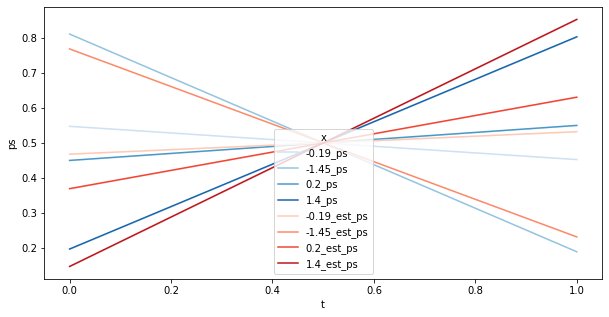

In [13]:
plt.figure(figsize=(10,5))
sns.lineplot(data=cop_df.assign(x = lambda d: d["x"].astype(str)+"_ps"),
             y="ps", x="t", hue="x", palette="Blues")

sns.lineplot(data=cop_df.assign(x = lambda d: d["x"].astype(str)+"_est_ps"),
             y="ps_est", x="t", hue="x", palette="Reds");

$$
E[Y_1|S=1] = \sum{Y\dfrac{\mathbb{1}(S=1)\mathbb{1}(T=1)}{P(T=1|X)}} \bigg/ \sum\dfrac{\mathbb{1}(S=1)\mathbb{1}(T=1)}{P(T=1|X)}
$$

In [14]:
(t*y*conv / ps.values).sum() / (conv*t/ps.values).sum()

25.20484257263347

$$
E[Y_1|S=1] = \sum{Y\dfrac{\mathbb{1}(S=1)\mathbb{1}(T=1)}{P(T=1|X, S=1)}} \bigg/ \sum\dfrac{\mathbb{1}(S=1)\mathbb{1}(T=1)}{P(T=1|X, S=1)}
$$

In [15]:
ps_est_df = df.merge(df.query("conv==1").groupby("x")["t"].mean().rename("ps_est").reset_index())

(ps_est_df.t*ps_est_df.y*ps_est_df.conv / ps_est_df.ps_est).sum() / (ps_est_df.conv*ps_est_df.t/ps_est_df.ps_est).sum()

25.13581701540483

In [16]:
cop_df.groupby("t").apply(lambda d: np.average(d["y"], weights=1/d["ps"]))

t
0    20.365534
1    25.204843
dtype: float64

In [17]:
cop_df.groupby("t").apply(lambda d: np.average(d["y"], weights=1/d["ps_est"]))

t
0    20.251360
1    25.135817
dtype: float64

In [18]:
conv_curve = df_w.groupby("t").apply(lambda d: np.average(d["conv"], weights=d["w"]))

In [19]:
(conv_curve*cop_df.groupby("t").apply(lambda d: np.average(d["y"], weights=d["w"]))).diff()

t
0         NaN
1    7.166125
dtype: float64

In [20]:
(conv_curve*cop_df.groupby("t").apply(lambda d: np.average(d["y"], weights=d["w_est"]))).diff()

t
0         NaN
1    7.175716
dtype: float64